# Evaluating Semantic Similarity

# **Llama 3B**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Specify the path to your JSON file
import json
file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_3b_factual_correctness.json'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Check if the loaded JSON is a list
if isinstance(predictions, list):
    # Assuming you want to process the first item in the list
    first_row = predictions[0]
else:
    first_row = predictions

# Extracting the required fields
findings = first_row["findings"]
predicted_impression = first_row["predicted_impression"]
actual_impression = first_row["actual_impression"]

In [ ]:
# Check if the loaded JSON is a list
if isinstance(predictions, list):
    # Assuming you want to process the first item in the list
    first_row = predictions[0]
else:
    first_row = predictions

# Print the first row
print("\nFirst row of data:")
for key, value in first_row.items():
    print(f"{key}: {value}")

# Extracting the required fields
findings = first_row["findings"]
predicted_impression = first_row["predicted_impression"]
actual_impression = first_row["actual_impression"]

print("\nFindings:")
print(findings)
print("\nPredicted Impression:")
print(predicted_impression)
print("\nActual Impression:")
print(actual_impression)


First row of data:
clinical_information: Clinical question: Prior MRI with questionable demyelinating disease. Please assess for new lesions. Signs and symptoms: Cognitive decline/depression.
findings: Pre-and post-enhanced MRI:No diffusion weighted abnormalities. Examination redemonstrates stable few subcortical and periventricular foci of flair hyperintensity in bilateral cerebral hemispheres. There is no evidence of any new lesions or any detectable abnormal enhancement.Previously noted lesions within bilateral middle cerebellar peduncles are significantly less conspicuous on current the study and there is no evidence of any new or enhancing lesions in the posterior fossa.Unremarkable cerebral cortex, cortical sulci, ventricular system and the CSF spaces for patient's stated age. No detectable abnormal parenchymal or leptomeningeal enhancement.Unremarkable images through the orbits and including axial fat sat post enhanced series.Unremarkable calvarium, soft tissues of the scalp, p

# Factual Correctness

In [ ]:
import statistics

# Extract the "factual_correction" values
factual_corrections = [entry['factual_correction'] for entry in predictions]

# Convert the values to floats (assuming they are strings in the JSON)
factual_corrections = [float(correction) for correction in factual_corrections]

# Compute the median
median_factual_correction = statistics.median(factual_corrections)

print(f"The median factual correctness out of a full score of 10 is: {median_factual_correction}")

The median factual correctness out of a full score of 10 is: 5.0


# BERTScore, ClinicalBERT Similarity and BERTScore

**BERTScore**

a) Encode both actual and predicted impressions using a pre-trained BERT mode: Both the predicted impression and actual impression are tokenized and passed through a pre-trained BERT model (e.g., bert-base-uncased).

b) Compute token-level embeddings:BERT outputs contextual embeddings for each token, capturing semantic and syntactic nuances.

c) Find the most similar token pairs between actual and predicted impressions:Each token in the predicted impression is matched to the most similar token in the actual impression, based on cosine similarity of their embeddings

d) Precision: Measures how much of the predicted text is relevant to the reference (actual impression). Calculated as the average cosine similarity of each predicted token's best match in the reference.

Recall: Measures how much of the reference text is captured by the predicted text. Calculated as the average cosine similarity of each reference token's best match in the predicted text.

F1 Score: The harmonic mean of Precision and Recall, balancing their importance.

**Key characteristics:**

Uses contextual embeddings

Captures semantic meaning beyond exact word matching

Handles paraphrasing and synonyms effectively

**ClinicalBERT and RadBERT Similarity (Cosine Similarity of Embeddings)
Embedding Generation Process:**

**Key Steps:**

a) Tokenization (Convert text to numerical tokens):The predicted impression and actual impression are tokenized and passed through ClinicalBERT (a variant of BERT fine-tuned on clinical texts).

b) Embedding Generation:

Use pre-trained medical domain models (ClinicalBERT/RadBERT)

Create contextual word embeddings with a specific focus on medical and clinical language for ClinicalBERT while RadBERT (e.g., bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12) is fine-tuned on radiology and medical datasets, enabling it to better capture nuances specific to radiological impressions.

c) Mean Pooling:
Aggregate token embeddings into a single sentence vector
Weighted by attention mask to ignore padding

d) Cosine Similarity Calculation:
Measure angle between two embedding vectors
1 - cosine distance gives similarity score
Ranges from 0 (completely different) to 1 (identical)


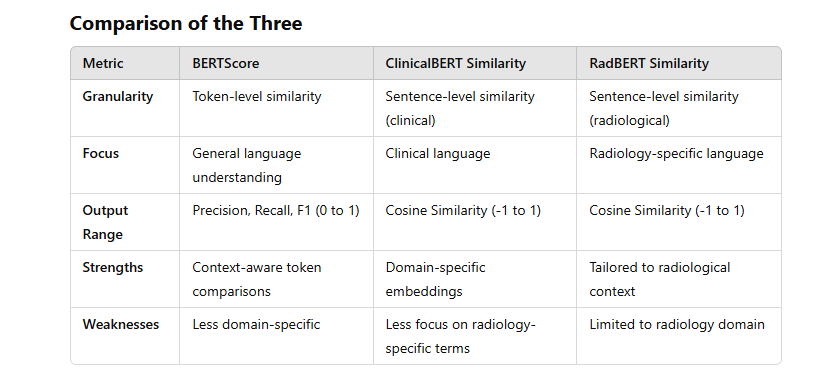

# BERTScore, ClinicalBERT Similarity, BERTScore, ROUGE Score and BLEU score

In [2]:
%%capture
!pip install bert-score transformers sentence-transformers


In [3]:
%%capture
!pip install transformers torch bert-score scipy

In [4]:
%%capture
!pip install rouge-score

In [ ]:
%%time

import json
import csv
from bert_score import score
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
from tqdm import tqdm  # for the progress bar

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_3b_factual_correctness.json'
output_csv = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_3b_evaluation_metrics.csv'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Load models
clinical_bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
radbert_tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT tokenizer if available
radbert_model = BertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT model if available

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothing_function = SmoothingFunction().method1

# Prepare CSV headers
csv_headers = ['clinical_information', 'findings', 'predicted_impression', 'actual_impression',
               'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
               'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
               'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
               'bleu_score', 'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
               'clinical_bert_similarity', 'radbert_similarity']

# Open CSV file for writing results
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)  # Write header row

    # Iterate over each row in the JSON file with a progress tracker
    for row in tqdm(predictions, desc="Processing", unit="row"):
        clinical_information = row['clinical_information']
        findings = row['findings']
        predicted_impression = row['predicted_impression']
        actual_impression = row['actual_impression']

        # Compute ROUGE scores
        rouge_scores = {
            'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
            'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
            'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
        }

        scores = scorer.score(actual_impression, predicted_impression)
        for metric in rouge_scores.keys():
            rouge_scores[metric]['precision'].append(scores[metric].precision)
            rouge_scores[metric]['recall'].append(scores[metric].recall)
            rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

        # Calculate average ROUGE scores
        average_rouge_scores = {
            metric: {
                'precision': sum(scores['precision']) / len(scores['precision']),
                'recall': sum(scores['recall']) / len(scores['recall']),
                'fmeasure': sum(scores['fmeasure']) / len(scores['fmeasure'])
            }
            for metric, scores in rouge_scores.items()
        }

        # Compute BLEU score
        actual_tokens = [actual_impression.split()]
        generated_tokens = predicted_impression.split()
        bleu_score = sentence_bleu(actual_tokens, generated_tokens, smoothing_function=smoothing_function)

        # Compute BERTScore
        P, R, F1 = score([predicted_impression], [actual_impression], lang='en', model_type='bert-base-uncased')

        # Compute ClinicalBERT similarity
        clinical_bert_inputs = clinical_bert_tokenizer([predicted_impression, actual_impression],
                                                       return_tensors='pt', padding=True, truncation=True, max_length=512)
        clinical_bert_outputs = clinical_bert_model(**clinical_bert_inputs)
        cls_embeddings = clinical_bert_outputs.last_hidden_state[:, 0, :]
        clinical_bert_similarity = torch.nn.functional.cosine_similarity(cls_embeddings[0].unsqueeze(0), cls_embeddings[1].unsqueeze(0)).item()

        # Compute RadBERT similarity
        radbert_inputs = radbert_tokenizer([predicted_impression, actual_impression],
                                           return_tensors='pt', padding=True, truncation=True, max_length=512)
        radbert_outputs = radbert_model(**radbert_inputs)
        radbert_embeddings = radbert_outputs.last_hidden_state[:, 0, :]
        radbert_similarity = torch.nn.functional.cosine_similarity(radbert_embeddings[0].unsqueeze(0), radbert_embeddings[1].unsqueeze(0)).item()

        # Prepare row data to write to CSV
        row_data = [
            clinical_information,
            findings,
            predicted_impression,
            actual_impression,
            average_rouge_scores['rouge1']['precision'],
            average_rouge_scores['rouge1']['recall'],
            average_rouge_scores['rouge1']['fmeasure'],
            average_rouge_scores['rouge2']['precision'],
            average_rouge_scores['rouge2']['recall'],
            average_rouge_scores['rouge2']['fmeasure'],
            average_rouge_scores['rougeL']['precision'],
            average_rouge_scores['rougeL']['recall'],
            average_rouge_scores['rougeL']['fmeasure'],
            bleu_score,
            P.item(), R.item(), F1.item(),
            clinical_bert_similarity,
            radbert_similarity
        ]

        # Write the row to the CSV file
        writer.writerow(row_data)

print(f"Evaluation metrics saved to {output_csv}")


Processing: 100%|██████████| 2749/2749 [1:49:59<00:00,  2.40s/row]

Evaluation metrics saved to /content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_3b_evaluation_metrics.csv
CPU times: user 1h 31min 25s, sys: 1min 25s, total: 1h 32min 51s
Wall time: 1h 50min 14s


In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_3b_evaluation_metrics.csv')

# List of columns to analyze
columns_to_analyze = [
   'clinical_bert_similarity', 'radbert_similarity',
   'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
   'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
   'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
   'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
   'bleu_score'
]

# Print average and median for each column
print("Metric Analysis:")
for column in columns_to_analyze:
   avg = df[column].mean()
   median = df[column].median()
   print(f"\n{column}:")
   print(f"  Average: {avg:.2f}")
   print(f"  Median:  {median:.2f}")

Metric Analysis:

clinical_bert_similarity:
  Average: 0.89
  Median:  0.90

radbert_similarity:
  Average: 0.94
  Median:  0.95

bert_score_precision:
  Average: 0.67
  Median:  0.68

bert_score_recall:
  Average: 0.65
  Median:  0.65

bert_score_f1:
  Average: 0.66
  Median:  0.66

rouge1_precision:
  Average: 0.43
  Median:  0.42

rouge1_recall:
  Average: 0.39
  Median:  0.37

rouge1_fmeasure:
  Average: 0.37
  Median:  0.37

rouge2_precision:
  Average: 0.21
  Median:  0.17

rouge2_recall:
  Average: 0.19
  Median:  0.15

rouge2_fmeasure:
  Average: 0.18
  Median:  0.16

rougeL_precision:
  Average: 0.32
  Median:  0.30

rougeL_recall:
  Average: 0.30
  Median:  0.26

rougeL_fmeasure:
  Average: 0.28
  Median:  0.26

bleu_score:
  Average: 0.08
  Median:  0.04


# **Llama 8B**

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_8b_factual_correctness.json'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Check if the loaded JSON is a list
if isinstance(predictions, list):
    # Assuming you want to process the first item in the list
    first_row = predictions[0]
else:
    first_row = predictions

# Extracting the required fields
findings = first_row["findings"]
predicted_impression = first_row["predicted_impression"]
actual_impression = first_row["actual_impression"]

# Factual Correctness

In [ ]:
import statistics

# Extract the "factual_correction" values
factual_corrections = [entry['factual_correction'] for entry in predictions]

# Convert the values to floats (assuming they are strings in the JSON)
factual_corrections = [float(correction) for correction in factual_corrections]

# Compute the median
median_factual_correction = statistics.median(factual_corrections)

print(f"The median factual correctness out of a full score of 10 is: {median_factual_correction}")

The median factual correctness out of a full score of 10 is: 5.0


# BERTScore, ClinicalBERT Similarity, BERTScore, ROUGE Score and BLEU score

In [5]:
%%time
import json
import csv
from bert_score import score
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
from tqdm import tqdm  # for the progress bar

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_8b_factual_correctness.json'
output_csv = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_8b_evaluation_metrics.csv'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Load models
clinical_bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
radbert_tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT tokenizer if available
radbert_model = BertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT model if available

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothing_function = SmoothingFunction().method1

# Prepare CSV headers
csv_headers = ['clinical_information', 'findings', 'predicted_impression', 'actual_impression',
               'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
               'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
               'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
               'bleu_score', 'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
               'clinical_bert_similarity', 'radbert_similarity']

# Open CSV file for writing results
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)  # Write header row

    # Iterate over each row in the JSON file with a progress tracker
    for row in tqdm(predictions, desc="Processing", unit="row"):
        clinical_information = row['clinical_information']
        findings = row['findings']
        predicted_impression = row['predicted_impression']
        actual_impression = row['actual_impression']

        # Compute ROUGE scores
        rouge_scores = {
            'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
            'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
            'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
        }

        scores = scorer.score(actual_impression, predicted_impression)
        for metric in rouge_scores.keys():
            rouge_scores[metric]['precision'].append(scores[metric].precision)
            rouge_scores[metric]['recall'].append(scores[metric].recall)
            rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

        # Calculate average ROUGE scores
        average_rouge_scores = {
            metric: {
                'precision': sum(scores['precision']) / len(scores['precision']),
                'recall': sum(scores['recall']) / len(scores['recall']),
                'fmeasure': sum(scores['fmeasure']) / len(scores['fmeasure'])
            }
            for metric, scores in rouge_scores.items()
        }

        # Compute BLEU score
        actual_tokens = [actual_impression.split()]
        generated_tokens = predicted_impression.split()
        bleu_score = sentence_bleu(actual_tokens, generated_tokens, smoothing_function=smoothing_function)

        # Compute BERTScore
        P, R, F1 = score([predicted_impression], [actual_impression], lang='en', model_type='bert-base-uncased')

        # Compute ClinicalBERT similarity
        clinical_bert_inputs = clinical_bert_tokenizer([predicted_impression, actual_impression],
                                                       return_tensors='pt', padding=True, truncation=True, max_length=512)
        clinical_bert_outputs = clinical_bert_model(**clinical_bert_inputs)
        cls_embeddings = clinical_bert_outputs.last_hidden_state[:, 0, :]
        clinical_bert_similarity = torch.nn.functional.cosine_similarity(cls_embeddings[0].unsqueeze(0), cls_embeddings[1].unsqueeze(0)).item()

        # Compute RadBERT similarity
        radbert_inputs = radbert_tokenizer([predicted_impression, actual_impression],
                                           return_tensors='pt', padding=True, truncation=True, max_length=512)
        radbert_outputs = radbert_model(**radbert_inputs)
        radbert_embeddings = radbert_outputs.last_hidden_state[:, 0, :]
        radbert_similarity = torch.nn.functional.cosine_similarity(radbert_embeddings[0].unsqueeze(0), radbert_embeddings[1].unsqueeze(0)).item()

        # Prepare row data to write to CSV
        row_data = [
            clinical_information,
            findings,
            predicted_impression,
            actual_impression,
            average_rouge_scores['rouge1']['precision'],
            average_rouge_scores['rouge1']['recall'],
            average_rouge_scores['rouge1']['fmeasure'],
            average_rouge_scores['rouge2']['precision'],
            average_rouge_scores['rouge2']['recall'],
            average_rouge_scores['rouge2']['fmeasure'],
            average_rouge_scores['rougeL']['precision'],
            average_rouge_scores['rougeL']['recall'],
            average_rouge_scores['rougeL']['fmeasure'],
            bleu_score,
            P.item(), R.item(), F1.item(),
            clinical_bert_similarity,
            radbert_similarity
        ]

        # Write the row to the CSV file
        writer.writerow(row_data)

print(f"Evaluation metrics saved to {output_csv}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing:   0%|          | 0/2749 [00:00<?, ?row/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing: 100%|██████████| 2749/2749 [1:46:45<00:00,  2.33s/row]

Evaluation metrics saved to /content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_8b_evaluation_metrics.csv
CPU times: user 1h 25min 14s, sys: 1min 30s, total: 1h 26min 45s
Wall time: 1h 48min 1s


In [6]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_8b_evaluation_metrics.csv')

# List of columns to analyze
columns_to_analyze = [
   'clinical_bert_similarity', 'radbert_similarity',
   'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
   'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
   'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
   'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
   'bleu_score'
]

# Print average and median for each column
print("Metric Analysis:")
for column in columns_to_analyze:
   avg = df[column].mean()
   median = df[column].median()
   print(f"\n{column}:")
   print(f"  Average: {avg:.2f}")
   print(f"  Median:  {median:.2f}")

Metric Analysis:

clinical_bert_similarity:
  Average: 0.90
  Median:  0.91

radbert_similarity:
  Average: 0.94
  Median:  0.95

bert_score_precision:
  Average: 0.69
  Median:  0.69

bert_score_recall:
  Average: 0.67
  Median:  0.67

bert_score_f1:
  Average: 0.67
  Median:  0.68

rouge1_precision:
  Average: 0.46
  Median:  0.44

rouge1_recall:
  Average: 0.43
  Median:  0.42

rouge1_fmeasure:
  Average: 0.40
  Median:  0.40

rouge2_precision:
  Average: 0.24
  Median:  0.20

rouge2_recall:
  Average: 0.23
  Median:  0.19

rouge2_fmeasure:
  Average: 0.21
  Median:  0.18

rougeL_precision:
  Average: 0.35
  Median:  0.32

rougeL_recall:
  Average: 0.34
  Median:  0.30

rougeL_fmeasure:
  Average: 0.31
  Median:  0.29

bleu_score:
  Average: 0.10
  Median:  0.05


In [7]:
%%time
import json
import csv
from bert_score import score
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
from tqdm import tqdm  # for the progress bar

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/Llama8b_results_1Epoch.json'
output_csv = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/Llama8b_results_1Epoch_evaluation_metrics.csv'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Load models
clinical_bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
radbert_tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT tokenizer if available
radbert_model = BertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT model if available

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothing_function = SmoothingFunction().method1

# Prepare CSV headers
csv_headers = ['clinical_information', 'findings', 'predicted_impression', 'actual_impression',
               'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
               'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
               'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
               'bleu_score', 'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
               'clinical_bert_similarity', 'radbert_similarity']

# Open CSV file for writing results
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)  # Write header row

    # Iterate over each row in the JSON file with a progress tracker
    for row in tqdm(predictions, desc="Processing", unit="row"):
        clinical_information = row['clinical_information']
        findings = row['findings']
        predicted_impression = row['predicted_impression']
        actual_impression = row['actual_impression']

        # Compute ROUGE scores
        rouge_scores = {
            'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
            'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
            'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
        }

        scores = scorer.score(actual_impression, predicted_impression)
        for metric in rouge_scores.keys():
            rouge_scores[metric]['precision'].append(scores[metric].precision)
            rouge_scores[metric]['recall'].append(scores[metric].recall)
            rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

        # Calculate average ROUGE scores
        average_rouge_scores = {
            metric: {
                'precision': sum(scores['precision']) / len(scores['precision']),
                'recall': sum(scores['recall']) / len(scores['recall']),
                'fmeasure': sum(scores['fmeasure']) / len(scores['fmeasure'])
            }
            for metric, scores in rouge_scores.items()
        }

        # Compute BLEU score
        actual_tokens = [actual_impression.split()]
        generated_tokens = predicted_impression.split()
        bleu_score = sentence_bleu(actual_tokens, generated_tokens, smoothing_function=smoothing_function)

        # Compute BERTScore
        P, R, F1 = score([predicted_impression], [actual_impression], lang='en', model_type='bert-base-uncased')

        # Compute ClinicalBERT similarity
        clinical_bert_inputs = clinical_bert_tokenizer([predicted_impression, actual_impression],
                                                       return_tensors='pt', padding=True, truncation=True, max_length=512)
        clinical_bert_outputs = clinical_bert_model(**clinical_bert_inputs)
        cls_embeddings = clinical_bert_outputs.last_hidden_state[:, 0, :]
        clinical_bert_similarity = torch.nn.functional.cosine_similarity(cls_embeddings[0].unsqueeze(0), cls_embeddings[1].unsqueeze(0)).item()

        # Compute RadBERT similarity
        radbert_inputs = radbert_tokenizer([predicted_impression, actual_impression],
                                           return_tensors='pt', padding=True, truncation=True, max_length=512)
        radbert_outputs = radbert_model(**radbert_inputs)
        radbert_embeddings = radbert_outputs.last_hidden_state[:, 0, :]
        radbert_similarity = torch.nn.functional.cosine_similarity(radbert_embeddings[0].unsqueeze(0), radbert_embeddings[1].unsqueeze(0)).item()

        # Prepare row data to write to CSV
        row_data = [
            clinical_information,
            findings,
            predicted_impression,
            actual_impression,
            average_rouge_scores['rouge1']['precision'],
            average_rouge_scores['rouge1']['recall'],
            average_rouge_scores['rouge1']['fmeasure'],
            average_rouge_scores['rouge2']['precision'],
            average_rouge_scores['rouge2']['recall'],
            average_rouge_scores['rouge2']['fmeasure'],
            average_rouge_scores['rougeL']['precision'],
            average_rouge_scores['rougeL']['recall'],
            average_rouge_scores['rougeL']['fmeasure'],
            bleu_score,
            P.item(), R.item(), F1.item(),
            clinical_bert_similarity,
            radbert_similarity
        ]

        # Write the row to the CSV file
        writer.writerow(row_data)

print(f"Evaluation metrics saved to {output_csv}")


Processing: 100%|██████████| 2749/2749 [1:44:48<00:00,  2.29s/row]

Evaluation metrics saved to /content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/Llama8b_results_1Epoch_evaluation_metrics.csv
CPU times: user 1h 23min 24s, sys: 1min 24s, total: 1h 24min 49s
Wall time: 1h 44min 59s


In [8]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/Llama8b_results_1Epoch_evaluation_metrics.csv')

# List of columns to analyze
columns_to_analyze = [
   'clinical_bert_similarity', 'radbert_similarity',
   'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
   'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
   'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
   'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
   'bleu_score'
]

# Print average and median for each column
print("Metric Analysis:")
for column in columns_to_analyze:
   avg = df[column].mean()
   median = df[column].median()
   print(f"\n{column}:")
   print(f"  Average: {avg:.2f}")
   print(f"  Median:  {median:.2f}")

Metric Analysis:

clinical_bert_similarity:
  Average: 0.90
  Median:  0.92

radbert_similarity:
  Average: 0.95
  Median:  0.95

bert_score_precision:
  Average: 0.70
  Median:  0.71

bert_score_recall:
  Average: 0.68
  Median:  0.67

bert_score_f1:
  Average: 0.68
  Median:  0.68

rouge1_precision:
  Average: 0.48
  Median:  0.47

rouge1_recall:
  Average: 0.43
  Median:  0.41

rouge1_fmeasure:
  Average: 0.41
  Median:  0.41

rouge2_precision:
  Average: 0.26
  Median:  0.22

rouge2_recall:
  Average: 0.23
  Median:  0.19

rouge2_fmeasure:
  Average: 0.22
  Median:  0.19

rougeL_precision:
  Average: 0.37
  Median:  0.33

rougeL_recall:
  Average: 0.34
  Median:  0.29

rougeL_fmeasure:
  Average: 0.32
  Median:  0.29

bleu_score:
  Average: 0.11
  Median:  0.05


# **Llama 1B**

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_1b_factual_correctness.json'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Check if the loaded JSON is a list
if isinstance(predictions, list):
    # Assuming you want to process the first item in the list
    first_row = predictions[0]
else:
    first_row = predictions

# Extracting the required fields
findings = first_row["findings"]
predicted_impression = first_row["predicted_impression"]
actual_impression = first_row["actual_impression"]

# Factual Correctness

In [ ]:
import statistics

# Extract the "factual_correction" values
factual_corrections = [entry['factual_correction'] for entry in predictions]

# Convert the values to floats (assuming they are strings in the JSON)
factual_corrections = [float(correction) for correction in factual_corrections]

# Compute the median
median_factual_correction = statistics.median(factual_corrections)

print(f"The median factual correctness out of a full score of 10 is: {median_factual_correction}")

The median factual correctness out of a full score of 10 is: 5.0


# BERTScore, ClinicalBERT Similarity, BERTScore, ROUGE Score and BLEU score

In [9]:
%%time
import json
import csv
from bert_score import score
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
from tqdm import tqdm  # for the progress bar

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_1b_factual_correctness.json'
output_csv = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_1b_evaluation_metrics.csv'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Load models
clinical_bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
radbert_tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT tokenizer if available
radbert_model = BertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT model if available

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothing_function = SmoothingFunction().method1

# Prepare CSV headers
csv_headers = ['clinical_information', 'findings', 'predicted_impression', 'actual_impression',
               'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
               'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
               'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
               'bleu_score', 'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
               'clinical_bert_similarity', 'radbert_similarity']

# Open CSV file for writing results
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)  # Write header row

    # Iterate over each row in the JSON file with a progress tracker
    for row in tqdm(predictions, desc="Processing", unit="row"):
        clinical_information = row['clinical_information']
        findings = row['findings']
        predicted_impression = row['predicted_impression']
        actual_impression = row['actual_impression']

        # Compute ROUGE scores
        rouge_scores = {
            'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
            'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
            'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
        }

        scores = scorer.score(actual_impression, predicted_impression)
        for metric in rouge_scores.keys():
            rouge_scores[metric]['precision'].append(scores[metric].precision)
            rouge_scores[metric]['recall'].append(scores[metric].recall)
            rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

        # Calculate average ROUGE scores
        average_rouge_scores = {
            metric: {
                'precision': sum(scores['precision']) / len(scores['precision']),
                'recall': sum(scores['recall']) / len(scores['recall']),
                'fmeasure': sum(scores['fmeasure']) / len(scores['fmeasure'])
            }
            for metric, scores in rouge_scores.items()
        }

        # Compute BLEU score
        actual_tokens = [actual_impression.split()]
        generated_tokens = predicted_impression.split()
        bleu_score = sentence_bleu(actual_tokens, generated_tokens, smoothing_function=smoothing_function)

        # Compute BERTScore
        P, R, F1 = score([predicted_impression], [actual_impression], lang='en', model_type='bert-base-uncased')

        # Compute ClinicalBERT similarity
        clinical_bert_inputs = clinical_bert_tokenizer([predicted_impression, actual_impression],
                                                       return_tensors='pt', padding=True, truncation=True, max_length=512)
        clinical_bert_outputs = clinical_bert_model(**clinical_bert_inputs)
        cls_embeddings = clinical_bert_outputs.last_hidden_state[:, 0, :]
        clinical_bert_similarity = torch.nn.functional.cosine_similarity(cls_embeddings[0].unsqueeze(0), cls_embeddings[1].unsqueeze(0)).item()

        # Compute RadBERT similarity
        radbert_inputs = radbert_tokenizer([predicted_impression, actual_impression],
                                           return_tensors='pt', padding=True, truncation=True, max_length=512)
        radbert_outputs = radbert_model(**radbert_inputs)
        radbert_embeddings = radbert_outputs.last_hidden_state[:, 0, :]
        radbert_similarity = torch.nn.functional.cosine_similarity(radbert_embeddings[0].unsqueeze(0), radbert_embeddings[1].unsqueeze(0)).item()

        # Prepare row data to write to CSV
        row_data = [
            clinical_information,
            findings,
            predicted_impression,
            actual_impression,
            average_rouge_scores['rouge1']['precision'],
            average_rouge_scores['rouge1']['recall'],
            average_rouge_scores['rouge1']['fmeasure'],
            average_rouge_scores['rouge2']['precision'],
            average_rouge_scores['rouge2']['recall'],
            average_rouge_scores['rouge2']['fmeasure'],
            average_rouge_scores['rougeL']['precision'],
            average_rouge_scores['rougeL']['recall'],
            average_rouge_scores['rougeL']['fmeasure'],
            bleu_score,
            P.item(), R.item(), F1.item(),
            clinical_bert_similarity,
            radbert_similarity
        ]

        # Write the row to the CSV file
        writer.writerow(row_data)

print(f"Evaluation metrics saved to {output_csv}")


Processing: 100%|██████████| 2749/2749 [1:44:49<00:00,  2.29s/row]

Evaluation metrics saved to /content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_1b_evaluation_metrics.csv
CPU times: user 1h 24min 11s, sys: 1min 20s, total: 1h 25min 32s
Wall time: 1h 44min 58s


In [10]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothLlamal_1b_evaluation_metrics.csv')

# List of columns to analyze
columns_to_analyze = [
   'clinical_bert_similarity', 'radbert_similarity',
   'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
   'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
   'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
   'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
   'bleu_score'
]

# Print average and median for each column
print("Metric Analysis:")
for column in columns_to_analyze:
   avg = df[column].mean()
   median = df[column].median()
   print(f"\n{column}:")
   print(f"  Average: {avg:.2f}")
   print(f"  Median:  {median:.2f}")

Metric Analysis:

clinical_bert_similarity:
  Average: 0.89
  Median:  0.90

radbert_similarity:
  Average: 0.94
  Median:  0.94

bert_score_precision:
  Average: 0.66
  Median:  0.67

bert_score_recall:
  Average: 0.63
  Median:  0.63

bert_score_f1:
  Average: 0.64
  Median:  0.64

rouge1_precision:
  Average: 0.40
  Median:  0.38

rouge1_recall:
  Average: 0.36
  Median:  0.34

rouge1_fmeasure:
  Average: 0.33
  Median:  0.33

rouge2_precision:
  Average: 0.18
  Median:  0.14

rouge2_recall:
  Average: 0.17
  Median:  0.13

rouge2_fmeasure:
  Average: 0.15
  Median:  0.13

rougeL_precision:
  Average: 0.30
  Median:  0.27

rougeL_recall:
  Average: 0.28
  Median:  0.25

rougeL_fmeasure:
  Average: 0.25
  Median:  0.24

bleu_score:
  Average: 0.07
  Median:  0.03


In [11]:
%%time
import json
import csv
from bert_score import score
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
from tqdm import tqdm  # for the progress bar

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothllama_1b_1Epoch.json'
output_csv = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothllama_1b_1Epoch_evaluation_metrics.csv'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Load models
clinical_bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
radbert_tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT tokenizer if available
radbert_model = BertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT model if available

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothing_function = SmoothingFunction().method1

# Prepare CSV headers
csv_headers = ['clinical_information', 'findings', 'predicted_impression', 'actual_impression',
               'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
               'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
               'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
               'bleu_score', 'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
               'clinical_bert_similarity', 'radbert_similarity']

# Open CSV file for writing results
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)  # Write header row

    # Iterate over each row in the JSON file with a progress tracker
    for row in tqdm(predictions, desc="Processing", unit="row"):
        clinical_information = row['clinical_information']
        findings = row['findings']
        predicted_impression = row['predicted_impression']
        actual_impression = row['actual_impression']

        # Compute ROUGE scores
        rouge_scores = {
            'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
            'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
            'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
        }

        scores = scorer.score(actual_impression, predicted_impression)
        for metric in rouge_scores.keys():
            rouge_scores[metric]['precision'].append(scores[metric].precision)
            rouge_scores[metric]['recall'].append(scores[metric].recall)
            rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

        # Calculate average ROUGE scores
        average_rouge_scores = {
            metric: {
                'precision': sum(scores['precision']) / len(scores['precision']),
                'recall': sum(scores['recall']) / len(scores['recall']),
                'fmeasure': sum(scores['fmeasure']) / len(scores['fmeasure'])
            }
            for metric, scores in rouge_scores.items()
        }

        # Compute BLEU score
        actual_tokens = [actual_impression.split()]
        generated_tokens = predicted_impression.split()
        bleu_score = sentence_bleu(actual_tokens, generated_tokens, smoothing_function=smoothing_function)

        # Compute BERTScore
        P, R, F1 = score([predicted_impression], [actual_impression], lang='en', model_type='bert-base-uncased')

        # Compute ClinicalBERT similarity
        clinical_bert_inputs = clinical_bert_tokenizer([predicted_impression, actual_impression],
                                                       return_tensors='pt', padding=True, truncation=True, max_length=512)
        clinical_bert_outputs = clinical_bert_model(**clinical_bert_inputs)
        cls_embeddings = clinical_bert_outputs.last_hidden_state[:, 0, :]
        clinical_bert_similarity = torch.nn.functional.cosine_similarity(cls_embeddings[0].unsqueeze(0), cls_embeddings[1].unsqueeze(0)).item()

        # Compute RadBERT similarity
        radbert_inputs = radbert_tokenizer([predicted_impression, actual_impression],
                                           return_tensors='pt', padding=True, truncation=True, max_length=512)
        radbert_outputs = radbert_model(**radbert_inputs)
        radbert_embeddings = radbert_outputs.last_hidden_state[:, 0, :]
        radbert_similarity = torch.nn.functional.cosine_similarity(radbert_embeddings[0].unsqueeze(0), radbert_embeddings[1].unsqueeze(0)).item()

        # Prepare row data to write to CSV
        row_data = [
            clinical_information,
            findings,
            predicted_impression,
            actual_impression,
            average_rouge_scores['rouge1']['precision'],
            average_rouge_scores['rouge1']['recall'],
            average_rouge_scores['rouge1']['fmeasure'],
            average_rouge_scores['rouge2']['precision'],
            average_rouge_scores['rouge2']['recall'],
            average_rouge_scores['rouge2']['fmeasure'],
            average_rouge_scores['rougeL']['precision'],
            average_rouge_scores['rougeL']['recall'],
            average_rouge_scores['rougeL']['fmeasure'],
            bleu_score,
            P.item(), R.item(), F1.item(),
            clinical_bert_similarity,
            radbert_similarity
        ]

        # Write the row to the CSV file
        writer.writerow(row_data)

print(f"Evaluation metrics saved to {output_csv}")


Processing: 100%|██████████| 2749/2749 [1:43:11<00:00,  2.25s/row]

Evaluation metrics saved to /content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothllama_1b_1Epoch_evaluation_metrics.csv
CPU times: user 1h 22min 51s, sys: 1min 18s, total: 1h 24min 10s
Wall time: 1h 43min 21s


In [12]:

import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothllama_1b_1Epoch_evaluation_metrics.csv')

# List of columns to analyze
columns_to_analyze = [
   'clinical_bert_similarity', 'radbert_similarity',
   'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
   'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
   'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
   'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
   'bleu_score'
]

# Print average and median for each column
print("Metric Analysis:")
for column in columns_to_analyze:
   avg = df[column].mean()
   median = df[column].median()
   print(f"\n{column}:")
   print(f"  Average: {avg:.2f}")
   print(f"  Median:  {median:.2f}")

Metric Analysis:

clinical_bert_similarity:
  Average: 0.88
  Median:  0.90

radbert_similarity:
  Average: 0.94
  Median:  0.94

bert_score_precision:
  Average: 0.65
  Median:  0.66

bert_score_recall:
  Average: 0.63
  Median:  0.63

bert_score_f1:
  Average: 0.64
  Median:  0.64

rouge1_precision:
  Average: 0.38
  Median:  0.37

rouge1_recall:
  Average: 0.36
  Median:  0.33

rouge1_fmeasure:
  Average: 0.33
  Median:  0.32

rouge2_precision:
  Average: 0.18
  Median:  0.14

rouge2_recall:
  Average: 0.17
  Median:  0.13

rouge2_fmeasure:
  Average: 0.15
  Median:  0.12

rougeL_precision:
  Average: 0.29
  Median:  0.26

rougeL_recall:
  Average: 0.28
  Median:  0.24

rougeL_fmeasure:
  Average: 0.25
  Median:  0.23

bleu_score:
  Average: 0.07
  Median:  0.03


# **Mistral 7B**

In [ ]:
import json

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_7b_factual_correctness.json'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Check if the loaded JSON is a list
if isinstance(predictions, list):
    # Assuming you want to process the first item in the list
    first_row = predictions[0]
else:
    first_row = predictions

# Extracting the required fields
findings = first_row["findings"]
predicted_impression = first_row["predicted_impression"]
actual_impression = first_row["actual_impression"]

# Factual Correctness

In [ ]:
import statistics

# Extract the "factual_correction" values
factual_corrections = [entry['factual_correction'] for entry in predictions]

# Convert the values to floats (assuming they are strings in the JSON)
factual_corrections = [float(correction) for correction in factual_corrections]

# Compute the median
median_factual_correction = statistics.median(factual_corrections)

print(f"The median factual correctness out of a full score of 10 is: {median_factual_correction}")


The median factual correctness out of a full score of 10 is: 5.0


# BERTScore, ClinicalBERT Similarity, BERTScore, ROUGE Score and BLEU score

In [ ]:
%%time

import json
import csv
from bert_score import score
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
from tqdm import tqdm  # for the progress bar

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_7b_factual_correctness.json'
output_csv = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_7b_evaluation_metrics.csv'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Load models
clinical_bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
radbert_tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT tokenizer if available
radbert_model = BertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT model if available

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothing_function = SmoothingFunction().method1

# Prepare CSV headers
csv_headers = ['clinical_information', 'findings', 'predicted_impression', 'actual_impression',
               'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
               'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
               'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
               'bleu_score', 'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
               'clinical_bert_similarity', 'radbert_similarity']

# Open CSV file for writing results
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)  # Write header row

    # Iterate over each row in the JSON file with a progress tracker
    for row in tqdm(predictions, desc="Processing", unit="row"):
        clinical_information = row['clinical_information']
        findings = row['findings']
        predicted_impression = row['predicted_impression']
        actual_impression = row['actual_impression']

        # Compute ROUGE scores
        rouge_scores = {
            'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
            'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
            'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
        }

        scores = scorer.score(actual_impression, predicted_impression)
        for metric in rouge_scores.keys():
            rouge_scores[metric]['precision'].append(scores[metric].precision)
            rouge_scores[metric]['recall'].append(scores[metric].recall)
            rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

        # Calculate average ROUGE scores
        average_rouge_scores = {
            metric: {
                'precision': sum(scores['precision']) / len(scores['precision']),
                'recall': sum(scores['recall']) / len(scores['recall']),
                'fmeasure': sum(scores['fmeasure']) / len(scores['fmeasure'])
            }
            for metric, scores in rouge_scores.items()
        }

        # Compute BLEU score
        actual_tokens = [actual_impression.split()]
        generated_tokens = predicted_impression.split()
        bleu_score = sentence_bleu(actual_tokens, generated_tokens, smoothing_function=smoothing_function)

        # Compute BERTScore
        P, R, F1 = score([predicted_impression], [actual_impression], lang='en', model_type='bert-base-uncased')

        # Compute ClinicalBERT similarity
        clinical_bert_inputs = clinical_bert_tokenizer([predicted_impression, actual_impression],
                                                       return_tensors='pt', padding=True, truncation=True, max_length=512)
        clinical_bert_outputs = clinical_bert_model(**clinical_bert_inputs)
        cls_embeddings = clinical_bert_outputs.last_hidden_state[:, 0, :]
        clinical_bert_similarity = torch.nn.functional.cosine_similarity(cls_embeddings[0].unsqueeze(0), cls_embeddings[1].unsqueeze(0)).item()

        # Compute RadBERT similarity
        radbert_inputs = radbert_tokenizer([predicted_impression, actual_impression],
                                           return_tensors='pt', padding=True, truncation=True, max_length=512)
        radbert_outputs = radbert_model(**radbert_inputs)
        radbert_embeddings = radbert_outputs.last_hidden_state[:, 0, :]
        radbert_similarity = torch.nn.functional.cosine_similarity(radbert_embeddings[0].unsqueeze(0), radbert_embeddings[1].unsqueeze(0)).item()

        # Prepare row data to write to CSV
        row_data = [
            clinical_information,
            findings,
            predicted_impression,
            actual_impression,
            average_rouge_scores['rouge1']['precision'],
            average_rouge_scores['rouge1']['recall'],
            average_rouge_scores['rouge1']['fmeasure'],
            average_rouge_scores['rouge2']['precision'],
            average_rouge_scores['rouge2']['recall'],
            average_rouge_scores['rouge2']['fmeasure'],
            average_rouge_scores['rougeL']['precision'],
            average_rouge_scores['rougeL']['recall'],
            average_rouge_scores['rougeL']['fmeasure'],
            bleu_score,
            P.item(), R.item(), F1.item(),
            clinical_bert_similarity,
            radbert_similarity
        ]

        # Write the row to the CSV file
        writer.writerow(row_data)

print(f"Evaluation metrics saved to {output_csv}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing:   0%|          | 0/2749 [00:00<?, ?row/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Processing: 100%|██████████| 2749/2749 [2:16:38<00:00,  2.98s/row]

Evaluation metrics saved to /content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_7b_evaluation_metrics.csv
CPU times: user 1h 31min 4s, sys: 1min 27s, total: 1h 32min 31s
Wall time: 2h 17min 54s


In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_7b_evaluation_metrics.csv')

# List of columns to analyze
columns_to_analyze = [
   'clinical_bert_similarity', 'radbert_similarity',
   'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
   'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
   'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
   'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
   'bleu_score'
]

# Print average and median for each column
print("Metric Analysis:")
for column in columns_to_analyze:
   avg = df[column].mean()
   median = df[column].median()
   print(f"\n{column}:")
   print(f"  Average: {avg:.2f}")
   print(f"  Median:  {median:.2f}")

Metric Analysis:

clinical_bert_similarity:
  Average: 0.90
  Median:  0.91

radbert_similarity:
  Average: 0.95
  Median:  0.95

bert_score_precision:
  Average: 0.69
  Median:  0.70

bert_score_recall:
  Average: 0.68
  Median:  0.67

bert_score_f1:
  Average: 0.68
  Median:  0.68

rouge1_precision:
  Average: 0.46
  Median:  0.45

rouge1_recall:
  Average: 0.44
  Median:  0.41

rouge1_fmeasure:
  Average: 0.41
  Median:  0.40

rouge2_precision:
  Average: 0.25
  Median:  0.21

rouge2_recall:
  Average: 0.24
  Median:  0.19

rouge2_fmeasure:
  Average: 0.23
  Median:  0.19

rougeL_precision:
  Average: 0.37
  Median:  0.33

rougeL_recall:
  Average: 0.35
  Median:  0.30

rougeL_fmeasure:
  Average: 0.32
  Median:  0.29

bleu_score:
  Average: 0.11
  Median:  0.06


# **Mistral 22B**

In [ ]:
import json

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_22b_factual_correctness.json'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Check if the loaded JSON is a list
if isinstance(predictions, list):
    # Assuming you want to process the first item in the list
    first_row = predictions[0]
else:
    first_row = predictions

# Extracting the required fields
clinical_information=first_row["clinical_information"]
findings = first_row["findings"]
predicted_impression = first_row["predicted_impression"]
actual_impression = first_row["actual_impression"]
factual_correction = first_row["factual_correction"]

# Factual Correctness

In [ ]:
import statistics

# Load the JSON file
file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_22b_factual_correctness.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the "factual_correction" values
factual_corrections = [entry['factual_correction'] for entry in predictions]

# Convert the values to floats (assuming they are strings in the JSON)
factual_corrections = [float(correction) for correction in factual_corrections]

# Compute the median
median_factual_correction = statistics.median(factual_corrections)

print(f"The median factual correctness out of a full score of 10 is: {median_factual_correction}")


The median factual correctness out of a full score of 10 is: 6.0


# BERTScore, ClinicalBERT Similarity, BERTScore, ROUGE Score and BLEU score

In [ ]:
%%time

import json
import csv
from bert_score import score
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import torch
from tqdm import tqdm  # for the progress bar

file_path = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_22b_factual_correctness.json'
output_csv = '/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_22b_evaluation_metrics.csv'

# Load the JSON file
with open(file_path, 'r') as file:
    predictions = json.load(file)

# Load models
clinical_bert_tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
clinical_bert_model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
radbert_tokenizer = BertTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT tokenizer if available
radbert_model = BertModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')  # Replace with RadBERT model if available

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
smoothing_function = SmoothingFunction().method1

# Prepare CSV headers
csv_headers = ['clinical_information', 'findings', 'predicted_impression', 'actual_impression',
               'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
               'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
               'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
               'bleu_score', 'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
               'clinical_bert_similarity', 'radbert_similarity']

# Open CSV file for writing results
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(csv_headers)  # Write header row

    # Iterate over each row in the JSON file with a progress tracker
    for row in tqdm(predictions, desc="Processing", unit="row"):
        clinical_information = row['clinical_information']
        findings = row['findings']
        predicted_impression = row['predicted_impression']
        actual_impression = row['actual_impression']

        # Compute ROUGE scores
        rouge_scores = {
            'rouge1': {'precision': [], 'recall': [], 'fmeasure': []},
            'rouge2': {'precision': [], 'recall': [], 'fmeasure': []},
            'rougeL': {'precision': [], 'recall': [], 'fmeasure': []}
        }

        scores = scorer.score(actual_impression, predicted_impression)
        for metric in rouge_scores.keys():
            rouge_scores[metric]['precision'].append(scores[metric].precision)
            rouge_scores[metric]['recall'].append(scores[metric].recall)
            rouge_scores[metric]['fmeasure'].append(scores[metric].fmeasure)

        # Calculate average ROUGE scores
        average_rouge_scores = {
            metric: {
                'precision': sum(scores['precision']) / len(scores['precision']),
                'recall': sum(scores['recall']) / len(scores['recall']),
                'fmeasure': sum(scores['fmeasure']) / len(scores['fmeasure'])
            }
            for metric, scores in rouge_scores.items()
        }

        # Compute BLEU score
        actual_tokens = [actual_impression.split()]
        generated_tokens = predicted_impression.split()
        bleu_score = sentence_bleu(actual_tokens, generated_tokens, smoothing_function=smoothing_function)

        # Compute BERTScore
        P, R, F1 = score([predicted_impression], [actual_impression], lang='en', model_type='bert-base-uncased')

        # Compute ClinicalBERT similarity
        clinical_bert_inputs = clinical_bert_tokenizer([predicted_impression, actual_impression],
                                                       return_tensors='pt', padding=True, truncation=True, max_length=512)
        clinical_bert_outputs = clinical_bert_model(**clinical_bert_inputs)
        cls_embeddings = clinical_bert_outputs.last_hidden_state[:, 0, :]
        clinical_bert_similarity = torch.nn.functional.cosine_similarity(cls_embeddings[0].unsqueeze(0), cls_embeddings[1].unsqueeze(0)).item()

        # Compute RadBERT similarity
        radbert_inputs = radbert_tokenizer([predicted_impression, actual_impression],
                                           return_tensors='pt', padding=True, truncation=True, max_length=512)
        radbert_outputs = radbert_model(**radbert_inputs)
        radbert_embeddings = radbert_outputs.last_hidden_state[:, 0, :]
        radbert_similarity = torch.nn.functional.cosine_similarity(radbert_embeddings[0].unsqueeze(0), radbert_embeddings[1].unsqueeze(0)).item()

        # Prepare row data to write to CSV
        row_data = [
            clinical_information,
            findings,
            predicted_impression,
            actual_impression,
            average_rouge_scores['rouge1']['precision'],
            average_rouge_scores['rouge1']['recall'],
            average_rouge_scores['rouge1']['fmeasure'],
            average_rouge_scores['rouge2']['precision'],
            average_rouge_scores['rouge2']['recall'],
            average_rouge_scores['rouge2']['fmeasure'],
            average_rouge_scores['rougeL']['precision'],
            average_rouge_scores['rougeL']['recall'],
            average_rouge_scores['rougeL']['fmeasure'],
            bleu_score,
            P.item(), R.item(), F1.item(),
            clinical_bert_similarity,
            radbert_similarity
        ]

        # Write the row to the CSV file
        writer.writerow(row_data)

print(f"Evaluation metrics saved to {output_csv}")


Processing: 100%|██████████| 2749/2749 [1:38:26<00:00,  2.15s/row]

Evaluation metrics saved to /content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_22b_evaluation_metrics.csv
CPU times: user 1h 31min 37s, sys: 1min 25s, total: 1h 33min 3s
Wall time: 1h 38min 33s


In [ ]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Capstone2/FinalResults/slothMistral_22b_evaluation_metrics.csv')

# List of columns to analyze
columns_to_analyze = [
   'clinical_bert_similarity', 'radbert_similarity',
   'bert_score_precision', 'bert_score_recall', 'bert_score_f1',
   'rouge1_precision', 'rouge1_recall', 'rouge1_fmeasure',
   'rouge2_precision', 'rouge2_recall', 'rouge2_fmeasure',
   'rougeL_precision', 'rougeL_recall', 'rougeL_fmeasure',
   'bleu_score'
]

# Print average and median for each column
print("Metric Analysis:")
for column in columns_to_analyze:
   avg = df[column].mean()
   median = df[column].median()
   print(f"\n{column}:")
   print(f"  Average: {avg:.2f}")
   print(f"  Median:  {median:.2f}")

Metric Analysis:

clinical_bert_similarity:
  Average: 0.90
  Median:  0.91

radbert_similarity:
  Average: 0.95
  Median:  0.95

bert_score_precision:
  Average: 0.70
  Median:  0.70

bert_score_recall:
  Average: 0.69
  Median:  0.69

bert_score_f1:
  Average: 0.69
  Median:  0.69

rouge1_precision:
  Average: 0.48
  Median:  0.47

rouge1_recall:
  Average: 0.47
  Median:  0.44

rouge1_fmeasure:
  Average: 0.43
  Median:  0.42

rouge2_precision:
  Average: 0.27
  Median:  0.24

rouge2_recall:
  Average: 0.26
  Median:  0.21

rouge2_fmeasure:
  Average: 0.24
  Median:  0.21

rougeL_precision:
  Average: 0.38
  Median:  0.35

rougeL_recall:
  Average: 0.37
  Median:  0.33

rougeL_fmeasure:
  Average: 0.34
  Median:  0.31

bleu_score:
  Average: 0.12
  Median:  0.07
